# Анализ бизнес-метрик для Яндекс.Афиши

- Автор: Курочкина Анна.
- Дата: 09.09.2025

## Цель и задачи проекта

Цель проекта: выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами для сервиса Яндекс.Афиша.

Задачи проекта:
1. Загрузить данные и познакомиться с ними.
2. Провести предобработку данных и подготовить их к исследованию.
3. Провести исследовательский анализ данных.
4. Провести статистический анализ данных.
5. Составить общий вывод и рекомендации для сервиса Яндекс.Афиша. 

## Описание данных

В данном проекте для анализа используются три датасета.

## Структура проекта
- Шаг 1. Загрузка данных и ознакомление с ними.
- Шаг 2. Предобработка данных и подготовка их к исследованию.
- Шаг 3. Исследовательский анализ данных.
- Шаг 4. Статистический анализ данных.
- Шаг 5. Общий вывод и рекомендации.

### 1. Загрузка данных и ознакомление с ними
Загрузим необходимые для работы библиотеки и данные трёх датасетов.

In [1]:
# Импортируем библиотеки
import pandas as pd
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
import math
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Создаём датафреймы final_tickets_orders_df, final_tickets_events_df и final_tickets_tenge_df
final_tickets_orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
final_tickets_events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

Выведем первые строки датафреймов на экран, оценим корректность данных и их полноту.

In [3]:
# Выводим первые 5 строк датафрейма final_tickets_orders_df
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Выводим информацию о датафрейме final_tickets_orders_df
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Выводы о качестве и количестве данных:
- Датафрейм final_tickets_orders_df содержит 290849 строк и 14 столбцов. 
- Названия столбцов представлены корректно и соответствуют содержащейся в них информации.
- Типы данных в столбцах created_dt_msk и created_ts_msk лучше привести к типу данных для работы с датой и временем, так как в этих столбцах содержится информация о дате создания заказа и о дате и времени создания заказа соответственно. 
- Информацию о количестве дней, прошедших с предыдущей покупки, в столбце days_since_prev вероятно, стоит привести к целочисленному типу int8. 
- Пропуски содержатся только в столбце days_since_prev, что было заявлено и в описании данных. Соответственно, привести данные к целочисленному типу в этом столбце не получится.

Приступаем к знакомству с данными датафрейма final_tickets_events_df.

In [5]:
# Выводим первые 5 строк датафрейма final_tickets_events_df
final_tickets_events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
# Выводим информацию о датафрейме final_tickets_events_df
final_tickets_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Выводы о качестве и количестве данных:
- Датафрейм final_tickets_events_df содержит 22427 строк и 11 столбцов. 
- Названия столбцов представлены корректно и соответствуют содержащейся в них информации.
- Типы данных для столбцов подобраны корректно.
- Пропуски отсутствуют. 

Приступаем к знакомству с данными датафрейма final_tickets_tenge_df.

In [7]:
# Выводим первые 5 строк датафрейма final_tickets_tenge_df
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
# Выводим информацию о датафрейме final_tickets_tenge_df
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Выводы о качестве и количестве данных:
- Датафрейм final_tickets_tenge_df содержит 357 строк и 4 столбца. 
- Названия столбцов представлены корректно и соответствуют содержащейся в них информации.
- Тип данных для столбца data лучше изменить на тип данных для работы с датой.
- Пропуски отсутствуют. 

Первичное ознакомление с данными завершено. Приступаем к этапу предобработки данных. 

### 2. Предобработка данных и их подготовка к исследованию
На основе полученной ранее информации подготовим данные к дальнейшему исследованию.

In [9]:
# Приводим данные датафрейма final_tickets_orders_df к типу datetime
columns_to_convert = ['created_dt_msk', 'created_ts_msk']
for column in columns_to_convert:
    final_tickets_orders_df[column] = pd.to_datetime(final_tickets_orders_df[column])
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [10]:
# Проверяем полные дубликаты в датафрейме final_tickets_orders_df
final_tickets_orders_df.duplicated().sum()

0

In [11]:
# Проверяем неявные дубликаты в датафрейме final_tickets_orders_df
final_tickets_orders_df.duplicated(subset='order_id').sum()

0

In [12]:
# Проверяем дубликаты без столбца order_id в датафрейме final_tickets_orders_df
duplicates = final_tickets_orders_df.drop_duplicates(subset=final_tickets_orders_df.columns.drop('order_id'))
display(duplicates)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290844,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,Весь в билетах,4,9655.73,0.0
290845,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,Весь в билетах,6,14483.60,0.0
290846,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,Прачечная,2,4473.74,3.0
290847,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,Билеты без проблем,2,6615.34,NaN


В 290819 из 290849 строк не было обнаружено дубликатов при их поиске без учёта столбца order_id. Строки с дубликатами будем считать ошибкой в записи данных. Выявленные дубликаты удалим.

In [13]:
# Сохраняем датафрейм без дубликатов
final_tickets_orders_df = duplicates

In [14]:
# Выводим уникальные названия возрастных ограничений на экран для поиска неявных дубликатов
unique_ages = final_tickets_orders_df['age_limit'].unique()
print(unique_ages)

[16  0 18 12  6]


In [15]:
# Выводим уникальные названия валюты на экран для поиска неявных дубликатов
unique_currency = final_tickets_orders_df['currency_code'].unique()
print(unique_currency)

['rub' 'kzt']


In [16]:
# Выводим уникальные названия устройств на экран для поиска неявных дубликатов
unique_device = final_tickets_orders_df['device_type_canonical'].unique()
print(unique_device)

['mobile' 'desktop']


In [17]:
# Выводим уникальные названия билетных операторов на экран для поиска неявных дубликатов
unique_service = final_tickets_orders_df['service_name'].unique()
print(unique_service)

['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']


In [18]:
# Выводим уникальные названия сети кинотеатров на экран для поиска неявных дубликатов
unique_cinema_circuit = final_tickets_orders_df['cinema_circuit'].unique()
print(unique_cinema_circuit)

['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']


Типы данных представлены корректно. Обнаруженные дубликаты в датафрейме final_tickets_orders_df удалены. Явных дубликатов, а также невяных дубликатов в названиях билетных операторов, устройств, валюты, возрастного рейтинга и идентификатора заказа не обнаружено.

Проанализируем распределение выручки для заказов за рубли.

In [19]:
# Проведём фильтрацию данных по валюте = 'rub' для анализа выбросов
filtered_rub = final_tickets_orders_df[final_tickets_orders_df['currency_code'] == 'rub']

# Изучаем статистические показатели столбца revenue для рублей
print('Статистические показатели столбца revenue для данных в рублях:')
filtered_rub['revenue'].describe()

Статистические показатели столбца revenue для данных в рублях:


count    285750.000000
mean        547.590617
std         871.556472
min         -90.760000
25%         113.862500
50%         346.180000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

В статистических показателях столбца с информацией о выручке сервиса с продажи билетов в рублях большой показатель стандартного отклонения, что указывает на наличие выбросов в данных. Также существует большая разница между средним значением выручки и модой, что подтверждает наличие выбросов. Аномальными также можно считать отрицательные значения, на которые указывает значение минимальной выручки. Однако, такое значение может появиться, например из-за скидки от сервиса для привлечения клиентов. 

Построим диаграмму размаха.

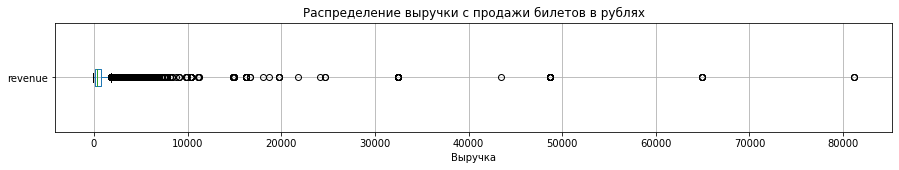

In [20]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 2))

# Строим диаграмму размаха значений в столбце seats
filtered_rub.boxplot(column='revenue', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение выручки с продажи билетов в рублях')
plt.xlabel('Выручка')

# Выводим график
plt.show()

В большинстве случаев выручка варьируется от 113 руб. до 791 руб. В данных существуют выбросы с правой стороны, идущие на увеличение значений. Большое скопление выбросов находится в промежутке от 791 руб. до 10000 руб. Наибольшее значение выручки равно 81174,5 руб. Вероятно, в данных, превышающих 10000 руб., может встречаться ошибка данных. Большие значения также могут быть связаны с тем, что один пользователь с одного аккаунта выкупил все билеты или большинство билетов на мероприятие. 

Построим диаграмму распределения выручки.

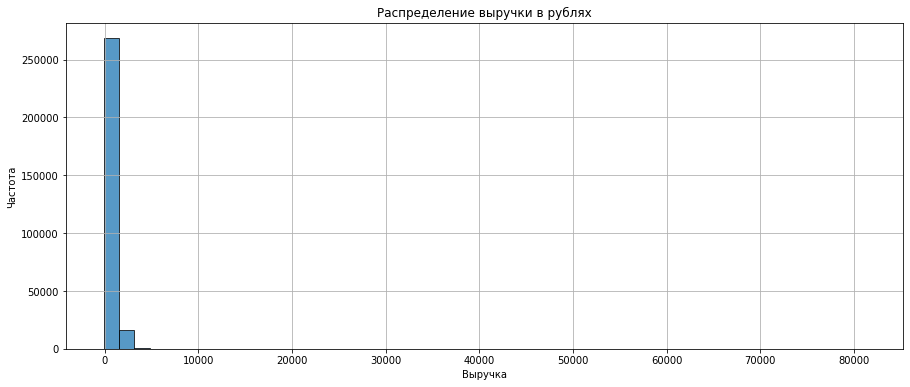

In [21]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
filtered_rub['revenue'].plot(
                kind='hist', # Тип графика - гистограмма
                bins = 50,
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение выручки в рублях')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

В связи с большим количеством аномальных выбросов, сосредоточенных в правом хвосте графика, в дальнейшем для анализа выберем данные, относящеися к промежутку до 99 перцентиля для исключения искажения результатов анализа, а также удалим отрицательные значения в столбце revenue.

Проанализируем распределение выручки для заказов за тенге.

In [22]:
# Проведём фильтрацию данных по валюте = 'kzt' для анализа выбросов
filtered_kzt = final_tickets_orders_df[final_tickets_orders_df['currency_code'] == 'kzt']

# Изучаем статистические показатели столбца revenue для рублей
print('Статистические показатели столбца revenue для данных в тенге:')
filtered_kzt['revenue'].describe()

Статистические показатели столбца revenue для данных в тенге:


count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

В статистических показателях столбца с информацией о выручке сервиса с продажи билетов в тенге высокий показатель стандартного отклонения, что указывает на наличие выбросов в данных. Также существует большая разница между средним значением выручки и модой, что подтверждает наличие выбросов. 

Построим диаграмму размаха.

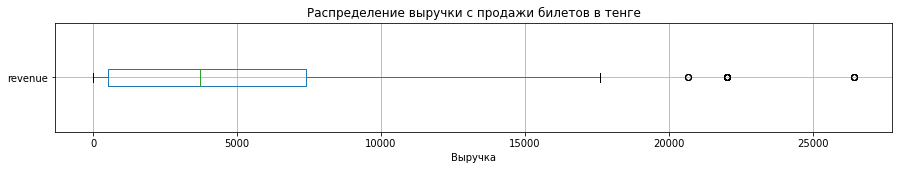

In [23]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 2))

# Строим диаграмму размаха значений в столбце seats
filtered_kzt.boxplot(column='revenue', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение выручки с продажи билетов в тенге')
plt.xlabel('Выручка')

# Выводим график
plt.show()

В большинстве случаев выручка варьируется от 518 тенге до 7397 тенге. В данных существуют выбросы с правой стороны, идущие на увеличение значений. Скоплений выбросов не наблюдается. Наибольшее значение выручки равно 26425,86 тенге. Вероятно, в данных может встречаться ошибка данных. 

Построим диаграмму распределения выручки.

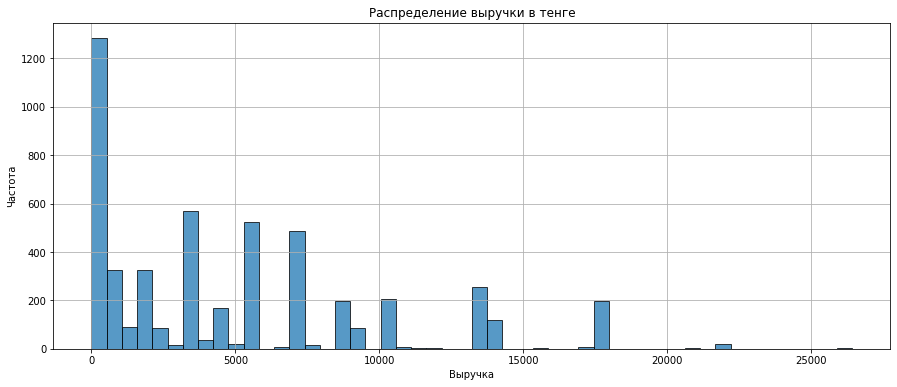

In [24]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
filtered_kzt['revenue'].plot(
                kind='hist', # Тип графика - гистограмма
                bins = 50,
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение выручки в тенге')
plt.xlabel('Выручка')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

В связи с аномальными выбросами, сосредоточенными в правом хвосте графика, в дальнейшем для анализа выберем данные, относящеися к промежутку до 99 перцентиля. 

Проанализируем распределение количества купленных билетов в заказе.

In [25]:
# Изучаем статистические показатели столбца tickets_count
print('Статистические показатели столбца tickets_count:')
final_tickets_orders_df['tickets_count'].describe()

Статистические показатели столбца tickets_count:


count    290819.000000
mean          2.754256
std           1.170461
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Значение стандартного отклонения находится на приемлемом уровне и свидетельствует о том, что аномалий в данных о количестве купленных билетов мало. Мода и среднее значение количества купленных билетов приближённо равны. 

Построим диаграмму размаха.

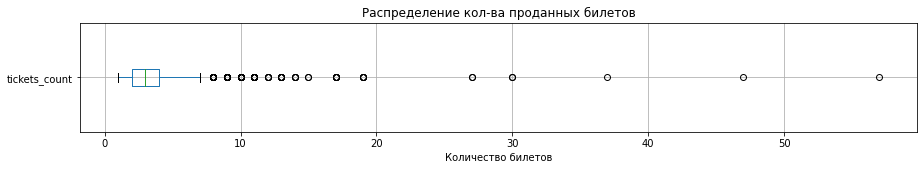

In [26]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 2))

# Строим диаграмму размаха значений в столбце seats
final_tickets_orders_df.boxplot(column='tickets_count', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение кол-ва проданных билетов')
plt.xlabel('Количество билетов')

# Выводим график
plt.show()

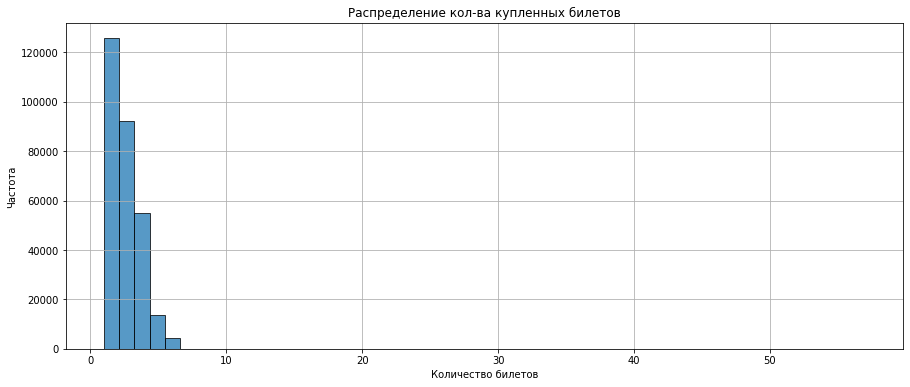

In [27]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(15, 6))

# Строим гистограмму с помощью pandas через plot(kind='hist')
final_tickets_orders_df['tickets_count'].plot(
                kind='hist', # Тип графика - гистограмма
                bins = 50,
                alpha=0.75,
                edgecolor='black',
                rot=0, # Градус вращения подписи по оси Х
)

# Настраиваем оформление графика
plt.title('Распределение кол-ва купленных билетов')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Чаще всего пользователи покупают менее 7 билетов. Выбросы с правой стороны усов диаграммы размаха будем считать особенностями конкретной покупки конкретного пользователя, а не как ошибки в данных. По столбцу с информацией о количестве билетов проводить удаление строк не будем.

Проанализируем явные и неявные дубликаты в данных датафрейма final_tickets_events_df.

In [28]:
# Проверяем полные дубликаты в датафрейме final_tickets_events_df
final_tickets_events_df.duplicated().sum()

0

In [29]:
# Проверяем неявные дубликаты в датафрейме final_tickets_events_df
final_tickets_events_df.duplicated(subset='event_id').sum()

0

In [30]:
# Выводим уникальные описания типов мероприятия на экран для поиска неявных дубликатов
unique_event_type = final_tickets_events_df['event_type_description'].unique()
print(unique_event_type)

['спектакль' 'балет' 'мюзикл' 'опера' 'концерт' 'шоу' 'ёлка'
 'цирковое шоу' 'событие' 'фестиваль' 'спортивное мероприятие' 'выставка'
 'спорт' 'оперетта' 'экскурсия' 'рок-мюзикл' 'музыкальный спектакль'
 'снегурочка' 'подарок' 'кукольный спектакль']


In [31]:
# Выводим уникальные типы мероприятий на экран для поиска неявных дубликатов
unique_type_main = final_tickets_events_df['event_type_main'].unique()
print(unique_type_main)

['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']


In [32]:
# Выводим уникальные названия регионов на экран для поиска неявных дубликатов
unique_region_name = final_tickets_events_df['region_name'].unique()
print(unique_region_name)

['Североярская область' 'Светополянский округ' 'Каменевский регион'
 'Лесодальний край' 'Медовская область' 'Широковская область'
 'Тепляковская область' 'Травяная область' 'Зоринский регион'
 'Серебринская область' 'Яблоневская область' 'Глиногорская область'
 'Речиновская область' 'Озернинский край' 'Горицветская область'
 'Солнечнореченская область' 'Травиницкий округ' 'Солнечноземская область'
 'Ключеводский округ' 'Островная область' 'Луговая область'
 'Каменноозёрный край' 'Лесостепной край' 'Зеленоградский округ'
 'Поленовский край' 'Лугоградская область' 'Синегорский регион'
 'Малиновая область' 'Речицкая область' 'Дальнеземская область'
 'Заречная область' 'Североозёрский округ' 'Дальнезорский край'
 'Малиновоярский округ' 'Сосновская область' 'Златопольский округ'
 'Ягодиновская область' 'Берестовский округ' 'Золотоключевской край'
 'Каменноярский край' 'Голубевский округ' 'Боровлянский край'
 'Тихореченская область' 'Миропольская область' 'Радужнопольский край'
 'Белоярская 

In [33]:
# Выводим уникальные названия городов на экран для поиска неявных дубликатов
unique_city_name = final_tickets_events_df['city_name'].unique()
print(unique_city_name)

['Озёрск' 'Глиноград' 'Глиногорск' 'Родниковец' 'Радужсвет' 'Радужнополье'
 'Горнодолинск' 'Родниковск' 'Луговинск' 'Озёрчане' 'Светополье'
 'Теплоозеро' 'Дальнесветск' 'Лесоярич' 'Островецк' 'Озёрово' 'Сосновечин'
 'Ягодиновка' 'Родниковецк' 'Глинополье' 'Акбасты' 'Лесоводск' 'Синеводов'
 'Ордакент' 'Крутовинск' 'Шаныртау' 'Дальнозолотск' 'Кристалевск'
 'Вишнёво' 'Тихоярск' 'Сарыжар' 'Радужанов' 'Теплоозёрск' 'Каменевский'
 'Островополь' 'Кенесар' 'Рощино' 'Верховино' 'Сосновогорец' 'Дальнозерск'
 'Солчелуг' 'Дальнополин' 'Кумсай' 'Каменосветск' 'Речинцево' 'Светогория'
 'Поленоозёрово' 'Поляногорье' 'Дальнесоснов' 'Заречиновка' 'Радужнояр'
 'Каменский' 'Речевинец' 'Ордасай' 'Песковино' 'Медовецк' 'Акбастау'
 'Луговаярово' 'Травяниново' 'Каражол' 'Глиногорь' 'Дальнесветин'
 'Горнополец' 'Травогород' 'Серебрянка' 'Сосноград' 'Малиновец'
 'Никольянов' 'Каменёвка' 'Синегориново' 'Солнечегорск' 'Горнополянск'
 'Серебровино' 'Каменозолото' 'Светочистенск' 'Родничанск' 'Вишнёвогорск'
 'Глин

Дубликатов в датафрейме final_tickets_events_df не побнаружено. Данные датафрейма готовы к дальнейшему анализу.

Приступаем к работе с датафреймом final_tickets_tenge_df.

In [34]:
# Приводим тип данных столбца data датафрейма final_tickets_tenge_df к типу datetime
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [35]:
# Проверяем полные дубликаты в датафрейме final_tickets_tenge_df
final_tickets_tenge_df.duplicated().sum()

0

In [36]:
# Проверяем неявные дубликаты в датафрейме final_tickets_tenge_df
final_tickets_tenge_df.duplicated(subset='data').sum()

0

Типы данных представлены корректно. Дубликатов в датафрейме final_tickets_tenge_df не побнаружено. Данные датафрейма готовы к дальнейшему анализу. 

Создадим несколько новых столбцов в исходном датафрейме final_tickets_orders_df.

In [37]:
# Объединим датафреймы final_tickets_orders_df и final_tickets_tenge_df по столбцу с указанием даты
final_tickets_orders_df = final_tickets_orders_df.merge(final_tickets_tenge_df, left_on='created_dt_msk', 
                                                        right_on='data', how='left')
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,2024-10-04,100,19.6648,kzt


In [38]:
# Создадим столбец revenue_rub для приведения размера выручки к единой валюте
final_tickets_orders_df['revenue_rub'] = final_tickets_orders_df.apply(lambda row: 
                                                                       row['revenue'] if row['currency_code'] == 'rub' 
                                                                       else row['revenue'] / 100 * row['curs'], axis=1)
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,2024-08-20,100,18.6972,kzt,1521.94
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,2024-07-23,100,18.3419,kzt,289.45
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,2024-10-06,100,19.6475,kzt,1258.57
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN,2024-07-13,100,18.5010,kzt,8.49
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,2024-10-04,100,19.6648,kzt,1390.41


In [39]:
# Изучаем статистические показатели столбца revenue_rub
print('Статистические показатели столбца revenue_rub:')
final_tickets_orders_df['revenue_rub'].describe()

Статистические показатели столбца revenue_rub:


count    290819.000000
mean        555.150647
std         875.309593
min         -90.760000
25%         113.400000
50%         350.330000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Как и на начальном этапе анализа данных, в столбце с конвертированной выручкой в рублях имеются отрицательные значения и аномально высокие значения. Удалим отрицательные значения и значения выше 99 перцентиля из датафрейма final_tickets_orders_df.

In [40]:
# Удаляем строки с отрицательными значениями в столбце revenue_rub
final_tickets_orders_df = final_tickets_orders_df.loc[(final_tickets_orders_df['revenue_rub'] >= 0)].dropna()

# Удаляем строки с аномально высокими значениями в столбце revenue_rub (выше 99 перцентиля)
# Вычисляем 99-й перцентиль
perc_99 = final_tickets_orders_df['revenue_rub'].quantile(0.99)  

# Удаляем строки, где значения в столбце revenue_rub выше 99-го перцентиля
final_tickets_orders_df = final_tickets_orders_df[final_tickets_orders_df['revenue_rub'] <= perc_99]

# Проверяем изменения статистических показателей
final_tickets_orders_df['revenue_rub'].describe()

count    265907.000000
mean        515.573479
std         511.074069
min           0.000000
25%         110.560000
50%         340.690000
75%         785.690000
max        2628.421739
Name: revenue_rub, dtype: float64

После удаления отрицательных значений и аномально высоких значений разница между средним показателем выручки и 50-м перцентилем сократилась, уменьшилось значение стандартного отклонения, значительно сократился показатель максимального значения выручки. Эти данные подходят для дальнейшего анализа. 

In [41]:
# Создадим столбец one_ticket_revenue_rub с информацией о средней выручке с одного купленного билета
final_tickets_orders_df['one_ticket_revenue_rub'] = final_tickets_orders_df['revenue_rub'] / final_tickets_orders_df['tickets_count']

final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,2024-10-06,100,19.6475,kzt,1258.57,314.642500
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0,2024-10-04,100,19.6648,kzt,1390.41,463.470000
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,Облачко,3,8206.70,19.0,2024-10-23,100,20.0531,kzt,902.74,300.913333
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,Лучшие билеты,2,2494.73,16.0,2024-10-15,100,19.7185,kzt,74.84,37.420000
10,6818133,000cf0659a9f40f,2024-06-20,2024-06-20 12:47:22,516728,нет,12,rub,mobile,1066.43,Лови билет!,3,13330.40,0.0,2024-06-20,100,18.0419,kzt,1066.43,355.476667


In [42]:
# Создадим столбец month с номером месяца, в котором был сделан заказ
final_tickets_orders_df['month'] = final_tickets_orders_df['created_dt_msk'].dt.month
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,tickets_count,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,4,13984.16,75.0,2024-10-06,100,19.6475,kzt,1258.57,314.642500,10
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,3,10695.43,83.0,2024-10-04,100,19.6648,kzt,1390.41,463.470000,10
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,...,3,8206.70,19.0,2024-10-23,100,20.0531,kzt,902.74,300.913333,10
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,...,2,2494.73,16.0,2024-10-15,100,19.7185,kzt,74.84,37.420000,10
10,6818133,000cf0659a9f40f,2024-06-20,2024-06-20 12:47:22,516728,нет,12,rub,mobile,1066.43,...,3,13330.40,0.0,2024-06-20,100,18.0419,kzt,1066.43,355.476667,6


In [43]:
# Создадим функцию для определения номера месяца и в соответствии с этим определим сезон
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

final_tickets_orders_df['season'] = final_tickets_orders_df['month'].apply(get_season)
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,total,days_since_prev,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,13984.16,75.0,2024-10-06,100,19.6475,kzt,1258.57,314.642500,10,осень
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10695.43,83.0,2024-10-04,100,19.6648,kzt,1390.41,463.470000,10,осень
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,...,8206.70,19.0,2024-10-23,100,20.0531,kzt,902.74,300.913333,10,осень
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,...,2494.73,16.0,2024-10-15,100,19.7185,kzt,74.84,37.420000,10,осень
10,6818133,000cf0659a9f40f,2024-06-20,2024-06-20 12:47:22,516728,нет,12,rub,mobile,1066.43,...,13330.40,0.0,2024-06-20,100,18.0419,kzt,1066.43,355.476667,6,лето


In [44]:
# Присоединяем датафрейм final_tickets_events_df к полученному датафрейму final_tickets_orders_df
final_tickets_orders_df = final_tickets_orders_df.merge(final_tickets_events_df, on='event_id', how='left')

In [45]:
# Изучим информацию о датафрейме после завершения этапа предобработки данных и их подготовки к исследованию
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265907 entries, 0 to 265906
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                265907 non-null  int64         
 1   user_id                 265907 non-null  object        
 2   created_dt_msk          265907 non-null  datetime64[ns]
 3   created_ts_msk          265907 non-null  datetime64[ns]
 4   event_id                265907 non-null  int64         
 5   cinema_circuit          265907 non-null  object        
 6   age_limit               265907 non-null  int64         
 7   currency_code           265907 non-null  object        
 8   device_type_canonical   265907 non-null  object        
 9   revenue                 265907 non-null  float64       
 10  service_name            265907 non-null  object        
 11  tickets_count           265907 non-null  int64         
 12  total                   265907

In [46]:
# Подсчёт доли пропусков в столбце region_name
share = final_tickets_orders_df['region_name'].isna().sum() / len(final_tickets_orders_df)
print(share)

0.0007935105130741198


По итогам предобработки данных и их подготовки к исследованию мы объёдинили три исходных датафрейма: final_tickets_orders_df,  final_tickets_events_df и final_tickets_tenge_df. В данные были добавлены 4 новых столбца: revenue_rub с указанием размера выручки в рублях, one_ticket_revenue_rub со средними значениями выручки с продажи одного билета, month с номером месяца покупки билетов, season с указанием сезона покупки билетов. Аномальные значения выручки были удалены и не будут использоваться в дальнейшем анализе. 

В итоге мы получили датафрейм final_tickets_orders_df с 265907 строками и 32 столбцами. 

### 3. Исследовательский анализ данных

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается. Изучим изменение пользовательской активности или пользовательского интереса в связи с сезонностью. 

In [47]:
# Группируем данные по месяцам и подсчитываем количество заказов для каждого месяца
total_orders = final_tickets_orders_df['order_id'].nunique()
count_orders = final_tickets_orders_df.groupby(by='month')['order_id'].nunique().reset_index(name='orders')
count_orders['share_of_orders'] = count_orders['orders'] / total_orders
display(count_orders)

,month,orders,share_of_orders
0,6,27820,0.104623
1,7,36653,0.137841
2,8,41142,0.154723
3,9,65293,0.245548
4,10,94999,0.357264


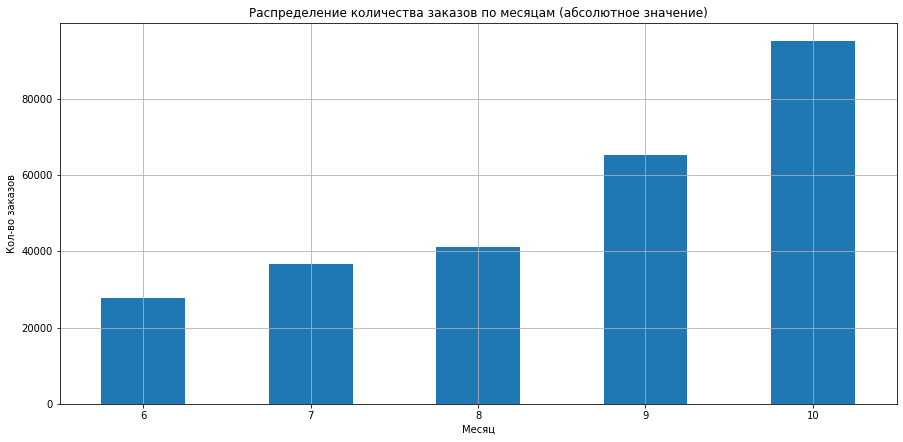

In [48]:
# Создаём визуализацию 
# Создаём контейнер графика matplotlib и задаём его размер
fig, ax = plt.subplots(figsize=(15, 7))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
count_orders.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               x='month', 
               y='orders',
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение количества заказов по месяцам (абсолютное значение)',
               ax=ax  # Указываем ось для построения графика
)

# Настраиваем оформление графика
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

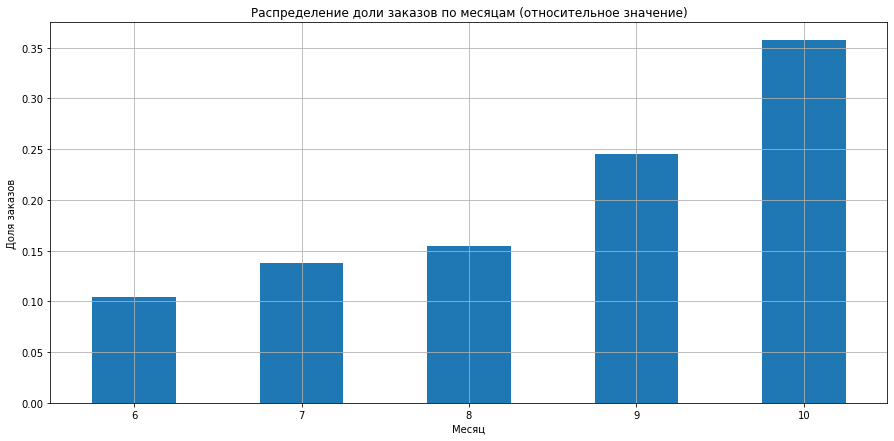

In [49]:
# Создаём визуализацию 
# Создаём контейнер графика matplotlib и задаём его размер
fig, ax = plt.subplots(figsize=(15, 7))

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
count_orders.plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               x='month', 
               y='share_of_orders',
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение доли заказов по месяцам (относительное значение)',
               ax=ax  # Указываем ось для построения графика
)

# Настраиваем оформление графика
plt.xlabel('Месяц')
plt.ylabel('Доля заказов')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

Вывод: для анализа представлены данные с июня по октябрь 2024 года. Количество заказов от июня к октябрю демонстирует устойчивый рост как в относительном, так и в абсолютном значении. При анализе столбчатой диаграммы видно, что количество заказов в июне почти в три раза меньше, чем количество заказов в октябре.

In [50]:
# Создаём сводную таблицу для вычисления кол-ва заказов по типу мероприятий за каждый сезон
type_event_count_orders = final_tickets_orders_df.groupby(by=['season', 'event_type_main'])['order_id'].nunique().reset_index(name='count_orders')
pivot_table_event = type_event_count_orders.pivot_table(index='season', columns='event_type_main', values='count_orders', aggfunc='sum')

display(pivot_table_event)

event_type_main,выставки,другое,концерты,спорт,стендап,театр,ёлки
season,,,,,,,
лето,2125,28746,44394,2743,5628,21541,248
осень,2276,31115,59490,18321,6537,40906,1626


In [51]:
# Вычисляем сумму заказов по каждому сезону и добавляем столбец total
pivot_table_event['total'] = pivot_table_event.sum(axis=1)  
display(pivot_table_event)

event_type_main,выставки,другое,концерты,спорт,стендап,театр,ёлки,total
season,,,,,,,,
лето,2125,28746,44394,2743,5628,21541,248,105425
осень,2276,31115,59490,18321,6537,40906,1626,160271


In [52]:
# Вычисляем долю заказов для каждой ячейки сводной таблицы
# Нормализуем данные
pivot_table_normalized = pivot_table_event.div(pivot_table_event['total'], axis=0)

# Удаляем столбец с общей суммой
pivot_table_normalized = pivot_table_normalized.drop('total', axis=1)

display(pivot_table_normalized)

event_type_main,выставки,другое,концерты,спорт,стендап,театр,ёлки
season,,,,,,,
лето,0.020157,0.272668,0.421096,0.026018,0.053384,0.204325,0.002352
осень,0.014201,0.194140,0.371184,0.114313,0.040787,0.255230,0.010145


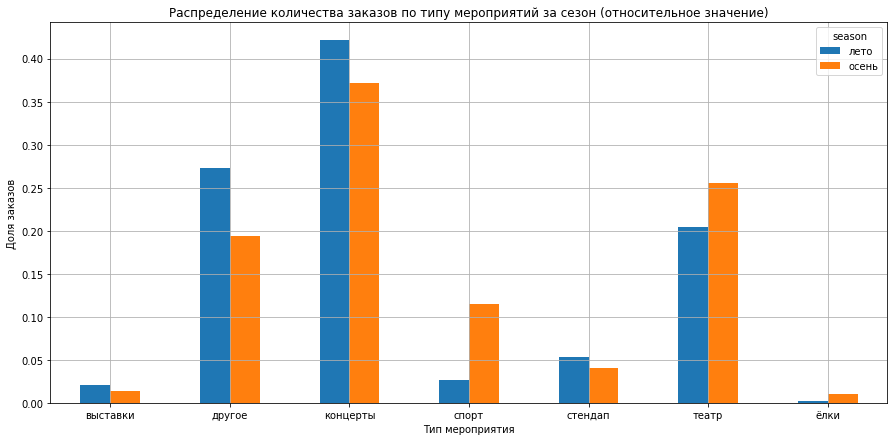

In [53]:
# Транспонируем таблицу
pivot_table_normalized_transposed = pivot_table_normalized.T

# Построим график
pivot_table_normalized_transposed.plot(kind='bar',
                            title='Распределение количества заказов по типу мероприятий за сезон (относительное значение)',
                            legend=True,
                            ylabel='Доля заказов',
                            xlabel='Тип мероприятия',
                            rot=0,
                            figsize=(15, 7))
plt.grid()
plt.show()

Вывод: количество заказов на покупку билетов на категории "другое", "концерты", "стендап" и "выставки" снизилась осенью относительно летнего периода. Осенью количество заказов билетов выросло на категории "спорт", "театр", "ёлки". Значительные изменения доли продаж наблюдаются в категориях "другое", "концерты", "спорт", "театр".

Проанализируем, как меняется активность пользователей в зависимости от типа устройства.

In [54]:
# Создаём сводную таблицу для вычисления кол-ва заказов по типу устройства за каждый сезон
device_count_orders = final_tickets_orders_df.groupby(by=['season', 'device_type_canonical'])['order_id'].nunique().reset_index(name='count_orders')
pivot_table_device = device_count_orders.pivot_table(index='season', columns='device_type_canonical', values='count_orders', aggfunc='sum')

display(pivot_table_device)

device_type_canonical,desktop,mobile
season,,
лето,20616,84999
осень,32987,127305


In [55]:
# Сумма заказов по каждому сезону
pivot_table_device['total'] = pivot_table_device.sum(axis=1)

In [56]:
# Вычисляем долю заказов для каждой ячейки сводной таблицы
# Нормализуем данные
pivot_table_device_normalized = pivot_table_device.div(pivot_table_device['total'], axis=0)

# Удаляем столбец с общей суммой
pivot_table_device_normalized = pivot_table_device_normalized.drop('total', axis=1)

display(pivot_table_device_normalized)

device_type_canonical,desktop,mobile
season,,
лето,0.195200,0.804800
осень,0.205793,0.794207


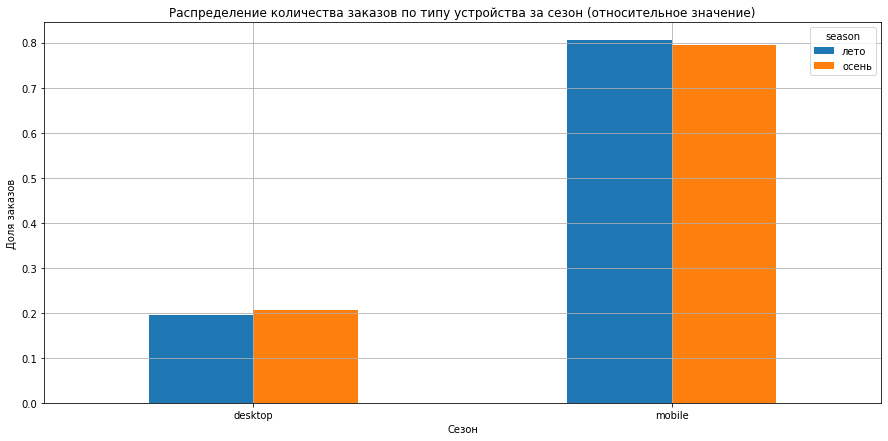

In [57]:
# Транспонируем таблицу
pivot_table_device_normalized_transposed = pivot_table_device_normalized.T

# Построим график
pivot_table_device_normalized_transposed.plot(kind='bar',
                                   title='Распределение количества заказов по типу устройства за сезон (относительное значение)',
                                   legend=True,
                                   ylabel='Доля заказов',
                                   xlabel='Сезон',
                                   rot=0,
                                   figsize=(15, 7))
plt.grid()
plt.show()

Вывод: доли пользователей, которые используют для покупки билетов мобильную и десктопную версию, не различаются в летний и осенний периоды.

Проанализируем, для каких возрастных категорий чаще всего были куплены билеты летом и осенью.

In [58]:
# Создаём сводную таблицу для вычисления кол-ва заказов по возрастному рейтингу за каждый сезон
ages_count_orders = final_tickets_orders_df.groupby(by=['season', 'age_limit'])['order_id'].nunique().reset_index(name='count_orders')
pivot_table_ages = ages_count_orders.pivot_table(index='season', columns='age_limit', values='count_orders', aggfunc='sum')

display(pivot_table_ages)

age_limit,0,6,12,16,18
season,,,,,
лето,18966,19325,21522,29809,15993
осень,37991,28201,35507,41984,16609


In [59]:
# Вычисляем сумму заказов по каждому сезону
pivot_table_ages['total'] = pivot_table_ages.sum(axis=1)

In [60]:
# Вычисляем долю заказов для каждой ячейки сводной таблицы
# Нормализуем данные
pivot_table_ages_normalized = pivot_table_ages.div(pivot_table_ages['total'], axis=0)

# Удаляем столбец с общей суммой
pivot_table_ages_normalized = pivot_table_ages_normalized.drop('total', axis=1)

display(pivot_table_ages_normalized)

age_limit,0,6,12,16,18
season,,,,,
лето,0.179577,0.182976,0.203778,0.282242,0.151427
осень,0.237011,0.175935,0.221514,0.261922,0.103617


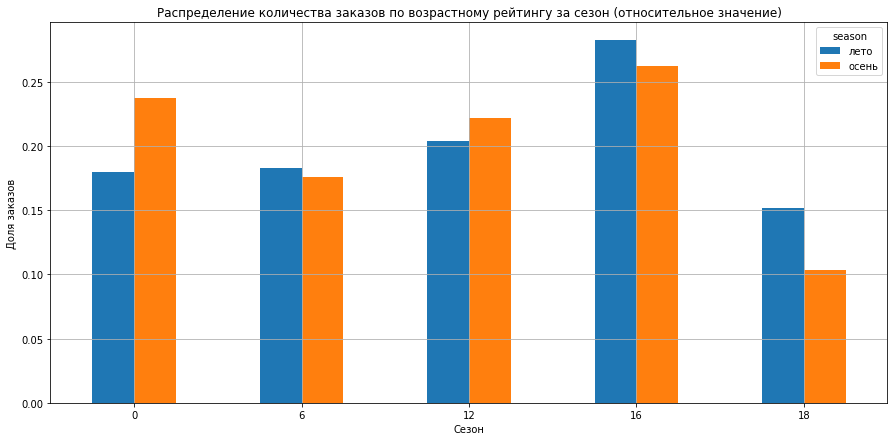

In [61]:
# Транспонируем таблицу
pivot_table_ages_normalized_transposed = pivot_table_ages_normalized.T

# Построим график
pivot_table_ages_normalized_transposed.plot(kind='bar',
                                   title='Распределение количества заказов по возрастному рейтингу за сезон (относительное значение)',
                                   legend=True,
                                   ylabel='Доля заказов',
                                   xlabel='Сезон',
                                   rot=0,
                                   figsize=(15, 7))
plt.grid()
plt.show()

Вывод: осенью чаще, чем летом, покупают билеты на мероприятия в рейтингом 0+, 12+. Снижение доли заказов осенью наблюдается для категорий 6+, 16+ и 18+.

Проанализируем изменения средней выручки с продажи билета в разрезе по типу мероприятий за лето и осень.

In [62]:
# Создаём сводную таблицу для вычисления средней выручки с продажи билета по типу мероприятий за каждый сезон
type_event_ticket_revenue = final_tickets_orders_df.groupby(by=['season', 'event_type_main'])['one_ticket_revenue_rub'].mean().reset_index(name='mean_revenue')
pivot_table_ticket_revenue = type_event_ticket_revenue.pivot_table(index='season', columns='event_type_main', values='mean_revenue')

display(pivot_table_ticket_revenue)

event_type_main,выставки,другое,концерты,спорт,стендап,театр,ёлки
season,,,,,,,
лето,86.558581,77.018670,302.661825,49.872573,220.682070,214.748878,269.946538
осень,92.359822,76.570016,269.227324,49.603320,230.780042,176.153686,229.129143


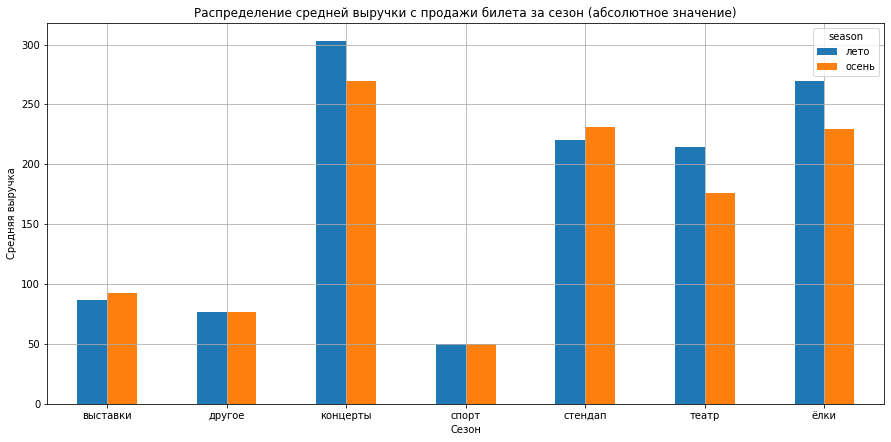

In [63]:
# Транспонируем таблицу
pivot_table_ticket_revenue_transposed = pivot_table_ticket_revenue.T
# Построим график
pivot_table_ticket_revenue_transposed.plot(kind='bar',
                                   title='Распределение средней выручки с продажи билета за сезон (абсолютное значение)',
                                   legend=True,
                                   ylabel='Средняя выручка',
                                   xlabel='Сезон',
                                   rot=0,
                                   figsize=(15, 7))
plt.grid()
plt.show()

Вывод: средняя выручка с продажи одного билета осенью выше для мероприятий "выставки", "стендап". Примечательно, что значительной динамики в количестве заказов для этих типов мероприятий для обоих сезонов отсутствует. Средняя выручка с продажи билета на концерты, театр и ёлки упала в осенний период. Неизменными остались показатели для спорта и категории "другое".

Проанализируем, как менялась выручка с одного билета осенью в отношении к полученной выручке летом. 

In [64]:
# Используем сводную таблицу pivot_table_ticket_revenue
changes_revenue = pivot_table_ticket_revenue.loc['осень'] / pivot_table_ticket_revenue.loc['лето'] - 1
display(changes_revenue)

event_type_main
выставки    0.067021
другое     -0.005825
концерты   -0.110468
спорт      -0.005399
стендап     0.045758
театр      -0.179722
ёлки       -0.151205
dtype: float64

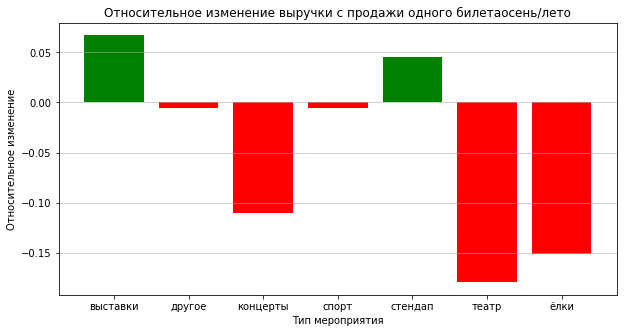

In [66]:
# Создаём столбчатую диаграмму
plt.figure(figsize=(10, 5))
plt.bar(changes_revenue.index, changes_revenue.values)

# Перебираем значения и задаем цвет в зависимости от знака
for i, val in enumerate(changes_revenue.values):
    color = 'green' if val >= 0 else 'red'
    plt.bar(changes_revenue.index[i], val, color=color)
    
plt.title('Относительное изменение выручки с продажи одного билетаосень/лето')
plt.xlabel('Тип мероприятия')
plt.ylabel('Относительное изменение')
plt.grid(axis='y', alpha=0.7)
plt.show()

Вывод: положительная динамика в показателе отношения выручки с продажи одного билета осенью к выручке летом наблюдается только у мероприятий типа выставка и стендап. Незначительные изменения наблюдаются в выручке с продажи мероприятий типа другое и спорт. Значительное снижение выручки с продажи билета наблюдается у концертов, театров и ёлок. 

 ### 3.2. Осенняя активность пользователей
Изучим активность пользователей осенью 2024 года. Используем только данные за осень.


In [67]:
# Проведём фильтрацию данных по сезону = 'осень' для анализа активности пользователей
filtered_autmn = final_tickets_orders_df[final_tickets_orders_df['season'] == 'осень']

In [68]:
# Считаем число заказов за каждый день
autmn_count_orders = filtered_autmn.groupby('created_dt_msk')['order_id'].nunique().reset_index(name='count_orders')

# Считаем число уникальных пользователей за каждый день
autmn_count_unique_users = filtered_autmn.groupby('created_dt_msk')['user_id'].nunique().reset_index(name='count_users')

# Объединяем полученные данные
autmn_count_orders = autmn_count_orders.merge(autmn_count_unique_users, on = 'created_dt_msk', how = 'left')
display(autmn_count_orders)

,created_dt_msk,count_orders,count_users
0,2024-09-01,1230,489
1,2024-09-02,1272,490
2,2024-09-03,4924,655
3,2024-09-04,1639,600
4,2024-09-05,1816,636
...,...,...,...
56,2024-10-27,2724,927
57,2024-10-28,2711,884
58,2024-10-29,2720,909
59,2024-10-30,2794,951


In [69]:
# Вычислим среднее число заказов на одного пользователя
autmn_count_orders['avg_orders'] = autmn_count_orders['count_orders'] / autmn_count_orders['count_users']
display(autmn_count_orders)

,created_dt_msk,count_orders,count_users,avg_orders
0,2024-09-01,1230,489,2.515337
1,2024-09-02,1272,490,2.595918
2,2024-09-03,4924,655,7.517557
3,2024-09-04,1639,600,2.731667
4,2024-09-05,1816,636,2.855346
...,...,...,...,...
56,2024-10-27,2724,927,2.938511
57,2024-10-28,2711,884,3.066742
58,2024-10-29,2720,909,2.992299
59,2024-10-30,2794,951,2.937960


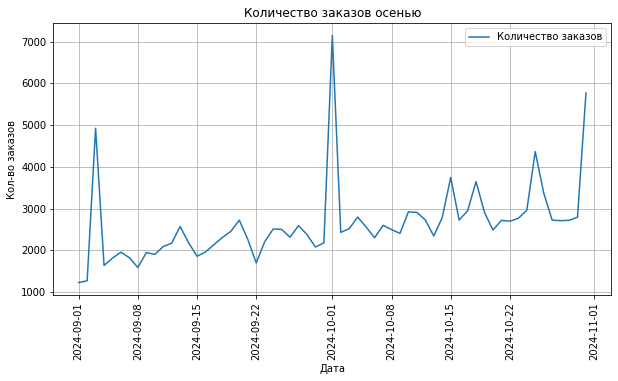

In [70]:
# Построим график общего числа заказов по дням
plt.figure(figsize=(10, 5))
plt.plot(autmn_count_orders['created_dt_msk'], autmn_count_orders['count_orders'], label='Количество заказов')
plt.title('Количество заказов осенью')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

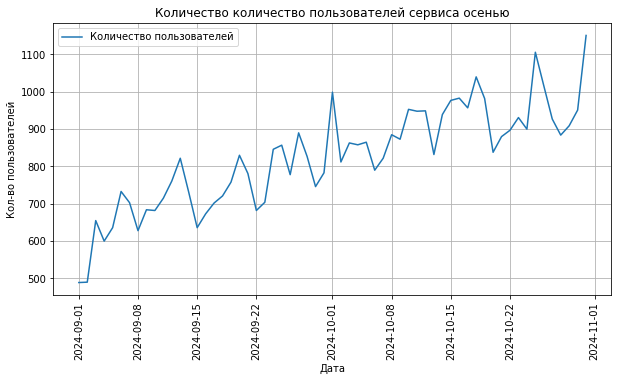

In [71]:
# Построим график общего числа пользователей по дням
plt.figure(figsize=(10, 5))
plt.plot(autmn_count_orders['created_dt_msk'], autmn_count_orders['count_users'], label='Количество пользователей')
plt.title('Количество количество пользователей сервиса осенью')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

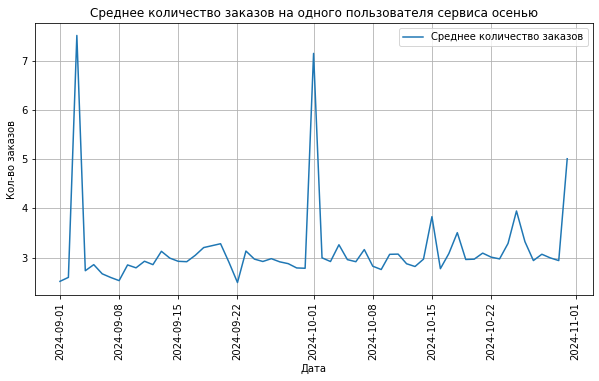

In [72]:
# Построим график среднего количества заказов на пользователя по дням
plt.figure(figsize=(10, 5))
plt.plot(autmn_count_orders['created_dt_msk'], autmn_count_orders['avg_orders'], label='Среднее количество заказов')
plt.title('Среднее количество заказов на одного пользователя сервиса осенью')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

Вывод: количество заказов и количество пользователей за два сентябрь и октябрь демонстирует параллельный рост, при этом динамика линий скачкообразная при сохранении общего трнеда на увеличение показателей. Количество заказов резко выросло в первую неделю сентября, в последние дни сентября и первые дни октября, в последние октября. В эти же приоды наблюдается резкий скачок среднего количества заказов на одного пользователя сервиса. Максимальное снижение показателей наблюдается 22 сентября.

Проанализируем динамику изменения средней выручки с продажи одного билета.

In [73]:
# Считаем среднюю выручку с одного билета за каждый день
autmn_revenue = filtered_autmn.groupby('created_dt_msk')['one_ticket_revenue_rub'].mean().reset_index(name='avg_revenue')
display(autmn_revenue)

,created_dt_msk,avg_revenue
0,2024-09-01,203.404152
1,2024-09-02,189.939700
2,2024-09-03,78.756626
3,2024-09-04,179.504619
4,2024-09-05,191.125487
...,...,...
56,2024-10-27,188.639822
57,2024-10-28,171.962385
58,2024-10-29,177.882715
59,2024-10-30,183.724113


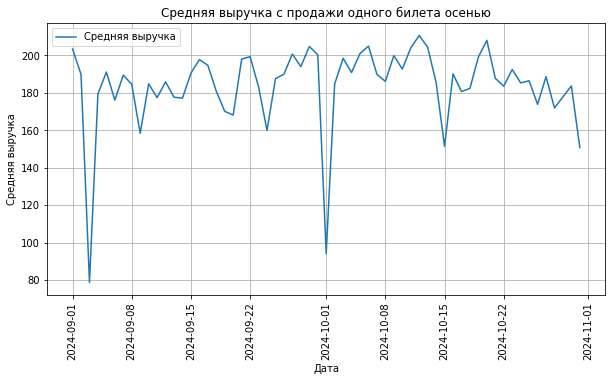

In [74]:
# Построим график средней выручки с продажи билета по дням
plt.figure(figsize=(10, 5))
plt.plot(autmn_revenue['created_dt_msk'], autmn_revenue['avg_revenue'], label='Средняя выручка')
plt.title('Средняя выручка с продажи одного билета осенью')
plt.xlabel('Дата')
plt.ylabel('Средняя выручка')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()

Вывод: средняя выручка с продажи одного билета резко падает в периоды максимального роста количества заказов. Вероятно, в эти дни проходила распродажа или акция. 22 сентября при наиболее низком показателе количества заказов на сохраняется относительно высокий показатель средней выручки с продажи одного билета. Тренд идёт на спад, линия скачкообразная. 

Проанализируем поведения пользователей в будние и в выходные дни.

In [75]:
# Создадим столбец для определения дня недели
filtered_autmn['day_of_week'] = filtered_autmn['created_dt_msk'].dt.weekday

# Создадим функцию для определения номера дня недели и в соответствии с этим разделим будни и выходные
def week(day):
    if day in [0, 1, 2, 3, 4]:
        return 'будний день'
    else:
        return 'выходной день'

filtered_autmn['type_day'] = filtered_autmn['day_of_week'].apply(week)
filtered_autmn.head()

/tmp/ipykernel_153/1477135564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_autmn['day_of_week'] = filtered_autmn['created_dt_msk'].dt.weekday
/tmp/ipykernel_153/1477135564.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_autmn['type_day'] = filtered_autmn['day_of_week'].apply(week)


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,day_of_week,type_day
0,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",6,выходной день
1,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",4,будний день
2,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.74,...,концерты,№1020,Лугоградская область,Кристалевск,193.0,930.0,"Школа живописи ""Солнце"" Групп","бул. Отрадный, д. 4 стр. 1",2,будний день
3,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.84,...,театр,№1637,Поленовский край,Дальнозолотск,18.0,3159.0,"Клуб начинающих писателей ""Таблицы"" Групп","ул. О.Кошевого, д. 7",1,будний день
17,2303442,001e7037d013f0f,2024-09-16,2024-09-16 21:13:17,494565,нет,16,rub,mobile,306.58,...,концерты,№881,Малиновоярский округ,Верховино,197.0,4113.0,"Мастерская живого действия ""Гардероб"" Лимитед","ш. 30 лет Победы, д. 38 стр. 664",0,будний день


In [76]:
# Считаем число заказов за будние и выходные дни
days_autmn_count_orders = filtered_autmn.groupby('type_day')['order_id'].nunique().reset_index(name='count_orders')
display(days_autmn_count_orders)

,type_day,count_orders
0,будний день,121759
1,выходной день,38533


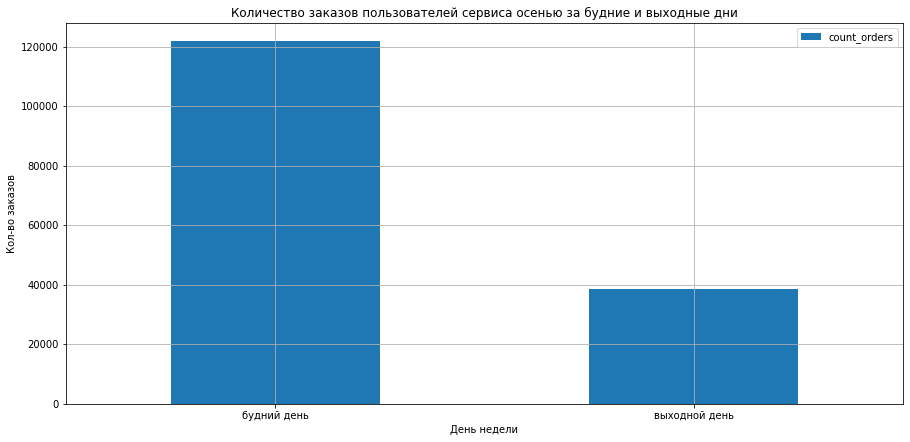

In [77]:
# Построим график
days_autmn_count_orders.plot(kind='bar',
                             x='type_day',
                                   title='Количество заказов пользователей сервиса осенью за будние и выходные дни',
                                   legend=True,
                                   ylabel='Кол-во заказов',
                                   xlabel='День недели',
                                   rot=0,
                                   figsize=(15, 7))
plt.grid()
plt.show()

Вывод: заказов билетов в будние дни в три раза больше, чем в выходные.

In [78]:
# Считаем число уникальных пользователей за будние и выходные дни
days_autmn_count_unique_users = filtered_autmn.groupby('type_day')['user_id'].nunique().reset_index(name='count_users')
display(days_autmn_count_unique_users)

,type_day,count_users
0,будний день,9699
1,выходной день,5635


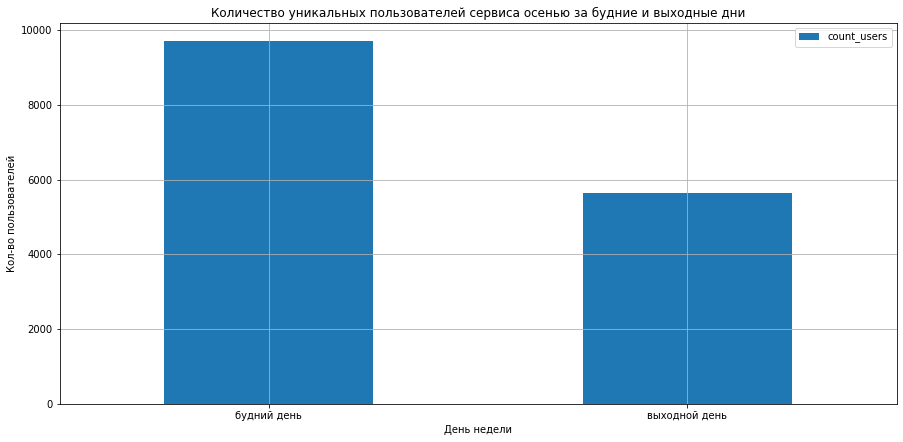

In [79]:
# Построим график
days_autmn_count_unique_users.plot(kind='bar',
                             x='type_day',
                                   title='Количество уникальных пользователей сервиса осенью за будние и выходные дни',
                                   legend=True,
                                   ylabel='Кол-во пользователей',
                                   xlabel='День недели',
                                   rot=0,
                                   figsize=(15, 7))
plt.grid()
plt.show()

Вывод: количество пользователей в абсолютном значении, использующих приложение в будние дни, почти в два раза больше, чем в выходные. Однако мы считаем, что будних дней в неделе 5, а выходных - 2. При интерпретации результатов стоит воспринимать данные с поправкой на разное количество дней в данных категориях.

Проверим активность пользователей через подсчёт среднего количества заказов на пользователя в будние и в выходные дни.

In [80]:
# Объединяем полученные данные за будние и выходные дни
days_autmn_count_orders = days_autmn_count_orders.merge(days_autmn_count_unique_users, on = 'type_day', how = 'left')
display(days_autmn_count_orders)

# Считаем среднее количество заказов пользователя за будние и выходные дни
days_autmn_count_orders['avg_orders'] = days_autmn_count_orders['count_orders'] / days_autmn_count_orders['count_users']
display(days_autmn_count_orders)

,type_day,count_orders,count_users
0,будний день,121759,9699
1,выходной день,38533,5635


,type_day,count_orders,count_users,avg_orders
0,будний день,121759,9699,12.553768
1,выходной день,38533,5635,6.838154


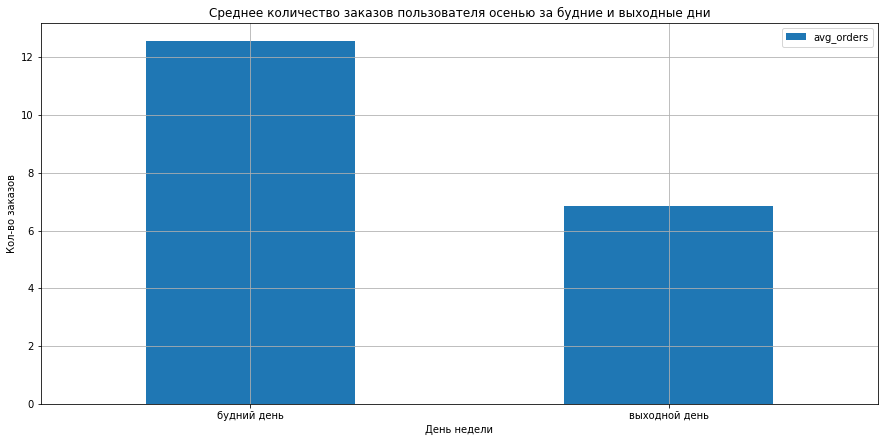

In [81]:
# Построим график
days_autmn_count_orders.plot(kind='bar',
                                   x='type_day',
                                   y = 'avg_orders',
                                   title='Среднее количество заказов пользователя осенью за будние и выходные дни',
                                   legend=True,
                                   ylabel='Кол-во заказов',
                                   xlabel='День недели',
                                   rot=0,
                                   figsize=(15, 7))
plt.grid()
plt.show()

Вывод: в будние дни клиент совершает около 13 заказов, в то время как в выходной день - около 7. 

В будние дни клиенты совершают больше заказов и чаще используют приложение, чем в выходные. 

### 3.3. Популярные события и партнёры
Выделим ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

In [82]:
# Вычислим количество заказов для каждого региона
regoin_count_orders = final_tickets_orders_df.groupby(by='region_name')['order_id'].nunique().reset_index(name='count_orders')
pivot_table_regoin = regoin_count_orders.pivot_table(index='region_name', values='count_orders', aggfunc='sum')
pivot_table_regoin = pivot_table_regoin.sort_values(by='count_orders', ascending=False)

display(pivot_table_regoin)

,count_orders
region_name,
Каменевский регион,82657
Североярская область,39942
Широковская область,14877
Медовская область,13513
Озернинский край,9732
...,...
Лесноярский край,16
Крутоводский регион,15
Верхозёрский край,10


In [83]:
# Вычисляем общее количество заказов
total_orders = final_tickets_orders_df['order_id'].nunique()

# Вычисляем долю количества заказов по регионам
pivot_table_regoin['part_of_all_orders'] = pivot_table_regoin['count_orders'] / total_orders

display(pivot_table_regoin)

,count_orders,part_of_all_orders
region_name,,
Каменевский регион,82657,0.310849
Североярская область,39942,0.150210
Широковская область,14877,0.055948
Медовская область,13513,0.050819
Озернинский край,9732,0.036599
...,...,...
Лесноярский край,16,0.000060
Крутоводский регион,15,0.000056
Верхозёрский край,10,0.000038


In [84]:
# Изучаем статистические показатели столбца count_orders
print('Статистические показатели столбца count_orders:')
pivot_table_regoin['count_orders'].describe()

Статистические показатели столбца count_orders:


count       81.000000
mean      3280.197531
std      10268.223941
min          4.000000
25%        248.000000
50%        756.000000
75%       2264.000000
max      82657.000000
Name: count_orders, dtype: float64

Вывод: всего сервис продаёт билеты в 81 регион. В ТОП-3 регионов по количеству заказов входят Каменевский регион, Североярская область и Широковская область. В АНТИТОП-3 входят Верхозёрский край, Сосноводолинская область, Теплоозёрский округ. Мода количества заказов для регионов - 756. Большинство значений не превосходят отметку в 2264 заказов. 

In [85]:
# Вычислим количество мероприятий для каждого региона
regoin_count_events = final_tickets_orders_df.groupby(by='region_name')['event_id'].nunique().reset_index(name='count_events')
pivot_table_events = regoin_count_events.pivot_table(index='region_name', values='count_events', aggfunc='sum')
pivot_table_events = pivot_table_events.sort_values(by='count_events', ascending=False)

display(pivot_table_events)

,count_events
region_name,
Каменевский регион,5716
Североярская область,3672
Широковская область,1198
Светополянский округ,1034
Речиновская область,677
...,...
Сосноводолинская область,2
Лесноярский край,2
Светолесский край,2


In [86]:
# Вычисляем общее количество мероприятий
total_events = final_tickets_orders_df['event_id'].nunique()

# Вычисляем долю количества мероприятий по регионам
pivot_table_events['part_of_all_events'] = pivot_table_events['count_events'] / total_events

display(pivot_table_events)

,count_events,part_of_all_events
region_name,,
Каменевский регион,5716,0.264568
Североярская область,3672,0.169961
Широковская область,1198,0.055450
Светополянский округ,1034,0.047859
Речиновская область,677,0.031335
...,...,...
Сосноводолинская область,2,0.000093
Лесноярский край,2,0.000093
Светолесский край,2,0.000093


In [87]:
# Изучаем статистические показатели столбца count_events
print('Статистические показатели столбца count_events:')
pivot_table_events['count_events'].describe()

Статистические показатели столбца count_events:


count      81.000000
mean      266.506173
std       761.168462
min         1.000000
25%        17.000000
50%        73.000000
75%       163.000000
max      5716.000000
Name: count_events, dtype: float64

Вывод: в ТОП-3 регионов по количеству мероприятий входят Каменевский регион, Североярская область и Широковская область (те же регионы, что входят в ТОП-3 по кол-ву заказов). В АНТИТОП-3 входят Верхозёрский край, Сосноводолинская область, Теплоозёрский округ (равно АНТИТОПУ-3 по кол-ву заказов). Мода количества мероприятий для регионов - 73. Большинство значений не превосходят отметку в 163 мероприятия. 

In [88]:
# Вычислим количество мероприятий для каждого партнёра
partners_count_events = final_tickets_orders_df.groupby(by='service_name')['event_id'].nunique().reset_index(name='count_events')
pivot_table_partners = partners_count_events.pivot_table(index='service_name', values='count_events', aggfunc='sum')
pivot_table_partners = pivot_table_partners.sort_values(by='count_events', ascending=False)

display(pivot_table_partners)

,count_events
service_name,
Лови билет!,4724
Билеты без проблем,4094
Билеты в руки,3404
Облачко,2246
Лучшие билеты,1714
Мой билет,1275
Тебе билет!,1026
Прачечная,989
Весь в билетах,822


In [89]:
# Изучаем статистические показатели столбца count_events
print('Статистические показатели столбца count_events:')
pivot_table_partners['count_events'].describe()

Статистические показатели столбца count_events:


count      36.000000
mean      654.500000
std      1178.661626
min         1.000000
25%        12.500000
50%       165.000000
75%       722.250000
max      4724.000000
Name: count_events, dtype: float64

Вывод: в ТОП-3 партнёров по количеству мероприятий входят Лови билет, Билеты без проблем, Билеты в руки. В АНТИТОП-3 входят Билеты в интернете, Зе Бест!, Кино билет. Мода количества мероприятий, представляемых партнёрами, 165. Большинство значений не превосходят отметку в 722 мероприятия.

In [90]:
# Вычислим количество заказов, обработанных каждым партнёром
partners_count_orders = final_tickets_orders_df.groupby(by='service_name')['order_id'].nunique().reset_index(name='count_orders')
pivot_table_partners_orders = partners_count_orders.pivot_table(index='service_name', values='count_orders', aggfunc='sum')
pivot_table_partners_orders = pivot_table_partners_orders.sort_values(by='count_orders', ascending=False)

display(pivot_table_partners_orders)

,count_orders
service_name,
Билеты без проблем,57835
Лови билет!,37953
Билеты в руки,37642
Мой билет,31195
Облачко,24226
Лучшие билеты,16544
Весь в билетах,15147
Прачечная,9639
Край билетов,5660


In [91]:
# Изучаем статистические показатели столбца count_orders
print('Статистические показатели столбца count_orders:')
pivot_table_partners_orders['count_orders'].describe()

Статистические показатели столбца count_orders:


count       36.000000
mean      7386.305556
std      13645.864068
min          4.000000
25%         85.000000
50%       1256.500000
75%       5082.500000
max      57835.000000
Name: count_orders, dtype: float64

Вывод: в ТОП-3 партнёров по количеству обработанных заказов входят Лови билет, Билеты без проблем, Билеты в руки (те же, что входят в ТОП-3 по кол-ку мероприятий). В АНТИТОП-3 входят Билеты в интернете, Зе Бест!, Лимоны. Мода количества обработанных заказов партнёрами - 1256. Большинство значений не превосходят отметку в 5082 обработанных заказа.

In [92]:
# Вычислим выручку, принесённую сервису от каждого партнёра
partners_revenue = final_tickets_orders_df.groupby(by='service_name')['revenue_rub'].sum().reset_index(name='sum_revenue')
pivot_table_partners_revenue = partners_revenue.pivot_table(index='service_name', values='sum_revenue')
pivot_table_partners_revenue = pivot_table_partners_revenue.sort_values(by='sum_revenue', ascending=False)

display(pivot_table_partners_revenue)

,sum_revenue
service_name,
Билеты без проблем,2.257064e+07
Мой билет,1.915461e+07
Облачко,1.706298e+07
Лови билет!,1.562206e+07
Весь в билетах,1.525536e+07
Билеты в руки,1.223549e+07
Край билетов,5.911622e+06
Прачечная,4.462354e+06
Дом культуры,4.031806e+06


In [93]:
# Изучаем статистические показатели столбца sum_revenue
print('Статистические показатели столбца sum_revenue:')
pivot_table_partners_revenue['sum_revenue'].describe()

Статистические показатели столбца sum_revenue:


count    3.600000e+01
mean     3.808183e+06
std      6.291241e+06
min      5.144000e+01
25%      6.088784e+04
50%      8.726933e+05
75%      3.730968e+06
max      2.257064e+07
Name: sum_revenue, dtype: float64

Вывод: в ТОП-3 партнёров по выручке входят Билеты без проблем, Мой билет и Облачко. В АНТИТОП-3 входят Билеты в интернете, Зе Бест!, Лимоны. Мода на выручку от партнёров - 872693,3 руб. Самое высокое значение выручки от партнёра составляет 22,5 млн руб.

### Шаг 4. Статистический анализ данных

Коллеги из продуктового отдела хотят отдельно проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств. Проверим две гипотезы.

**Гипотеза 1.**


Нулевая и альтернативная гипотезы:
- H₀: cреднее количество заказов на одного пользователя не различается для пользователей мобильного приложения и пользователей стационарных устройств.
- H₁: cреднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [94]:
# Считаем количество пользователей в группах A и B в абсолютном значении
groupA_users = filtered_autmn[filtered_autmn['device_type_canonical'] == 'mobile']['user_id'].nunique()
groupB_users = filtered_autmn[filtered_autmn['device_type_canonical'] == 'desktop']['user_id'].nunique()

print(f'Количество пользователей мобильных устройств: {groupA_users}') 
print(f'Количество пользователей десктопной версии: {groupB_users}') 

Количество пользователей мобильных устройств: 10194
Количество пользователей десктопной версии: 4036


In [95]:
# Считаем процентную разницу в количестве пользователей в группах A и B
percent = 100 * (groupA_users - groupB_users) / groupA_users
print(f'Процентная разница в количестве пользователей в группах A и B составляет {percent}%')

Процентная разница в количестве пользователей в группах A и B составляет 60.40808318618795%


In [96]:
# Находим пересечения значений user_id группах A и B
users_a = filtered_autmn[filtered_autmn['device_type_canonical'] == 'mobile']['user_id']
users_b = filtered_autmn[filtered_autmn['device_type_canonical'] == 'desktop']['user_id']

intersection = list(set(users_a) & set(users_b))
print(intersection)

['1a244475dda4fbb', '1050aa063a47748', '55e5d0ffdf48732', '04a307dc0bb54b7', '29424169530f6d0', '16d0729b8886d99', 'c7442f3dc601840', '3acaaa931f82ff6', '45b67db2c14ed34', '51b1a3a021c10e6', 'cf57d9b6a5d00fb', '69d4c1625995449', '6c94dea24d07f78', 'd6c165254af2361', 'e352253c40fcdfa', '5082f9b0ff01d8e', 'c07c6e600ed166f', 'abb563dde76a9e7', 'f79f8368c70e8d6', 'bbd02d4a3bdc14a', '63d3489c7c4b4f4', '919bfbbe437add2', '243ce3e0008cc67', 'd0bf3abcedcf7e1', '61a476128fbd669', '05ee512a6c80ab3', 'fa383294d84c739', '1d8867afe6cf87a', '1c92ebd22d77d88', 'c9057c415fe1006', '21d499897931441', '1c191bb7b007ba1', 'e400322ec0d54d1', '5edddf27193d021', '9baf50336ad7171', '671ab76357e9e0f', 'af180b27d38750a', '112f4a7abe0e18e', '8f4e4d4a4ae404e', '1d5fbea536442ab', '2244cd4dcf189c2', '4bbec686f343955', '4d9ee34038add57', 'f8592fc09148e8d', '560339c75ada42f', 'a5f182717b5ac20', 'aa4a07d8ec16af3', 'c09b3d0db079916', '99e2d4517d86b2b', '411816d6a0b7356', '143f1296c7c52fa', '04c2ea26ae0724b', '8b62406482

В данных обнаружено большое количество пользователей, которые используют и мобильную, и десктопную версию сервиса. Так как это может повлиять на поведение пользователей и исказить результаты проведения статистического теста, удалим пользователей, относящихся к обеим группам сразу.

In [97]:
# Удаляем строки с пересекающимися user_id из датафрейма filtered_autmn и создаём новый датафрейм ab_filtered_autmn
ab_filtered_autmn = filtered_autmn[~filtered_autmn['user_id'].isin(intersection)]

In [98]:
# Считаем количество пользователей в группах A и B в абсолютном значении
groupA_users = ab_filtered_autmn[ab_filtered_autmn['device_type_canonical'] == 'mobile']['user_id'].nunique()
groupB_users = ab_filtered_autmn[ab_filtered_autmn['device_type_canonical'] == 'desktop']['user_id'].nunique()

print(f'Количество пользователей мобильных устройств: {groupA_users}') 
print(f'Количество пользователей десктопной версии: {groupB_users}') 

Количество пользователей мобильных устройств: 7164
Количество пользователей десктопной версии: 1006


Количество пользователей мобильных утсройств больше, чем количество пользователей десктопной версии. Так как имеется разброс в количестве пользователей, в дальнейшем для проверки гипотез продуктовой команды будем использовать t-тест Уэлча из-за его устойчивости к разному количеству пользователей в группах. 

In [99]:
# Создадим сводную таблицу с данными о среднем количестве заказов на пользователя
ab_orders = ab_filtered_autmn.groupby(by='device_type_canonical')['order_id'].nunique().reset_index(name='count_orders')
pivot_ab_orders = ab_orders.pivot_table(index='device_type_canonical', values='count_orders', aggfunc='sum')

ab_users = ab_filtered_autmn.groupby(by='device_type_canonical')['user_id'].nunique().reset_index(name='count_users')
pivot_ab_users = ab_users.pivot_table(index='device_type_canonical', values='count_users', aggfunc='sum')

pivot_ab_orders_users = pivot_ab_orders.merge(pivot_ab_users, on='device_type_canonical', how='left')

pivot_ab_orders_users['avg_orders'] = pivot_ab_orders_users['count_orders'] / pivot_ab_orders_users['count_users']

display(pivot_ab_orders_users)

,count_orders,count_users,avg_orders
device_type_canonical,,,
desktop,2270,1006,2.256461
mobile,24807,7164,3.462730


В созданной сводной таблице видно, что среднее количество заказов на пользователя десктопной версии ниже, чем среднее количество заказов на пользователя мобильной версии. Вероятно, верна альтернативная гипотеза. Проверим эти выводы с помощью статистического t-теста Уэлча.

In [100]:
# Считаем количество заказов для пользователей группы A
orders_a = ab_filtered_autmn[ab_filtered_autmn['device_type_canonical'] == 'mobile'].groupby(by='user_id')['order_id'].nunique().reset_index(name='count_orders')
display(orders_a)

,user_id,count_orders
0,0005ca5e93f2cf4,1
1,000898990054619,2
2,000a55a418c128c,1
3,001e7037d013f0f,2
4,00245c702bc343e,2
...,...,...
7159,ffdfac9273f943b,1
7160,ffe364dd8211157,3
7161,ffe73c50cbd71fc,1
7162,ffed3ff067d4f12,3


In [101]:
# Изучаем статистические показатели столбца count_orders
print('Статистические показатели столбца count_orders:')
orders_a['count_orders'].describe()

Статистические показатели столбца count_orders:


count    7164.000000
mean        3.462730
std         4.820078
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       123.000000
Name: count_orders, dtype: float64

In [102]:
# Считаем количество заказов для пользователей группы B
orders_b = ab_filtered_autmn[ab_filtered_autmn['device_type_canonical'] == 'desktop'].groupby(by='user_id')['order_id'].nunique().reset_index(name='count_orders')
display(orders_b)

,user_id,count_orders
0,0040e12d70fae81,1
1,006d1660d830822,7
2,00cb8c1ef996876,1
3,00e62ce48c12cb4,1
4,00f5131ed2d9533,5
...,...,...
1001,ff2c56ee603b875,2
1002,ff31101eab14f41,2
1003,ffade91aac83ba3,3
1004,ffb556471d3ea4d,1


In [103]:
# Изучаем статистические показатели столбца count_orders
print('Статистические показатели столбца count_orders:')
orders_b['count_orders'].describe()

Статистические показатели столбца count_orders:


count    1006.000000
mean        2.256461
std         3.700455
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        55.000000
Name: count_orders, dtype: float64

Среднее значение количества заказов у пользователей мобильной версии выше, чем у пользователей десктопной версии. Проверим, насколько статистически значимо это различие с помощью t-Теста Уэлча.

In [104]:
# Проводим t-тест Уэлча
metric_a = orders_a['count_orders'] ## выборка целевой метрики для группы A
metric_b = orders_b['count_orders'] ## выборка целевой метрики для группы B

alpha = 0.05 # на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False, # дисперсии в группах A и B не равны
    alternative='greater' # поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки больше второй выборки
) ## применяем t-тест Уэлча

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {(p_value_welch_ttest)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: среднее количество заказов на одного пользователя мобильной и десктопной версии сервиса не различается')
else:
    print(f'p-value теста Уэлча = {(p_value_welch_ttest)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B меньше')
    print('Интерпретация: среднее количество заказов на одного пользователя мобильной версии сервиса больше количества заказов пользователя десктопной версии')

p-value теста Уэлча = 2.532058743027422e-20
Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B меньше
Интерпретация: среднее количество заказов на одного пользователя мобильной версии сервиса больше количества заказов пользователя десктопной версии


Для сравнения средних значений заказов на одного пользователя мобильной и десктопной версии сервиса был выбран t-тест Уэлча, так как он позволяет проводить статистический тест на неоднородном распределении количества участников в группах A и B, с чем мы и столкнулись в данной задаче. При таких условиях t-тест Уэлча обеспечивает достаточный уровень надёжности результатов. 

Уровень статистической значимости был установлен на стандартном уровне α = 0.05.

Результат теста, или p-value: в результате проведения t-теста Уэлча получено значение p-value = 0.00002.
Вывод на основе полученного p-value: поскольку полученное значение p-value = 0.0 ниже установленного уровня значимости α = 0.05, мы отвергаем нулевую гипотезу. Это означает, что статистически среднее количество заказов на одного пользователя мобильной версии сервиса больше количества заказов пользователя десктопной версии. Верна альтернативная гипотеза.

**Гипотеза 2.**

Нулевая и альтернативная гипотезы:
- H₀: cреднее время между заказами пользователей не различается для пользователей мобильного приложения и пользователей стационарных устройств.
- H₁: cреднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [105]:
# Изучаем статистические показатели столбца days_since_prev
print('Статистические показатели столбца days_since_prev:')
ab_filtered_autmn['days_since_prev'].describe()

Статистические показатели столбца days_since_prev:


count    27077.000000
mean        14.073199
std         26.216733
min          0.000000
25%          0.000000
50%          1.000000
75%         15.000000
max        148.000000
Name: days_since_prev, dtype: float64

Наименьшее значение количества дней между заказами равняется 0, а максимальное - 148.

In [106]:
# Проводим t-тест Уэлча
metric_a = ab_filtered_autmn[ab_filtered_autmn['device_type_canonical'] == 'mobile']['days_since_prev'] ## выборка целевой метрики для группы A
metric_b = ab_filtered_autmn[ab_filtered_autmn['device_type_canonical'] == 'desktop']['days_since_prev'] ## выборка целевой метрики для группы B

alpha = 0.05 # на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    metric_a, 
    metric_b, 
    equal_var=False, # дисперсии в группах A и B не равны
    alternative='greater' # поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки больше второй выборки
) ## применяем t-тест Уэлча

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча = {(p_value_welch_ttest)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: среднее время между заказами пользователей мобильной и десктопной версии сервиса не различается')
else:
    print(f'p-value теста Уэлча = {(p_value_welch_ttest)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B меньше')
    print('Интерпретация: среднее время между заказами пользователя мобильной версии сервиса больше среднего времени между заказами пользователя десктопной версии')

p-value теста Уэлча = 0.999999977738395
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: среднее время между заказами пользователей мобильной и десктопной версии сервиса не различается


Уровень статистической значимости был установлен на стандартном уровне α = 0.05.

Результат теста, или p-value: в результате проведения t-теста Уэлча получено значение p-value = 0.999999977738395.

Вывод на основе полученного p-value: поскольку полученное значение p-value = 0.999999977738395 больше установленного уровня значимости α = 0.05, мы не можем отвергнуть нулевую гипотезу. Это означает, что статистически среднее время между заказами пользователей мобильной и десктопной версии сервиса не различается. Верна нулевая гипотеза.

### Шаг 5. Общий вывод и рекомендации

В данном проекте для команды сервиса Яндекс.Афиша был проведён анализ данных для выявления закономерностей в поведении пользователей летом и осенью, анализ данных для выявления наиболее прибыльных и неприбыльных партнёров и регионов, а также A/B-тест в связи с использованием мобильной и десктопной версиями сервиса пользователями.

Предварительно данные прошли предобработку с удалением дубликатов, добавлением необходимых для анализа столбцов, изменением типов данных и объединением данных.

В результате проведения исследования были сделаны следующие выводы:
- Общее количество заказов растёт с каждым месяцем;
- Отмечено увеличение клиентской активности в категориях "спорт", "театр", "ёлки" в связи с ростом спроса на семейные мероприятия, что подтверждается ростом продаж билетов на категории мероприятий с возрастным рейтингом 0+ (возможно, это связано с возвращением к трудовым и учебным будням, и родителям снова стало актуально организовывать детям досуг и семейный отдых, в отличие от лета, когда приходит период отпусков);
- Тренд количества заказов и количества пользователей сервиса осенью демонстрирует рост;
- Средняя выручка с продажи одного билета осенью демонстирует снижение тренда;
- В будние дни клиенты совершают больше заказов и чаще используют приложение, чем в выходные;
- Во всех регионах, в которых работает сервис, проходят мероприятия, что также говорит о правильной работе по распространению работы приложения;
- Все партнёры приносят прибыль, но в разном количестве, значит, партнёрские отношения можно считать удачными;
- Среднее количество заказов на одного пользователя мобильной версии сервиса больше количества заказов пользователя десктопной версии;
- Среднее время между заказами пользователей мобильной и десктопной версии сервиса не различается;
- Вместе с увеличением количества заказов и количества пользователей осенью наблюдается снижение средней стоимости одного билета. Вероятно, это связано с изменением категорий мероприятий, на которые пользователи покупают билеты. Также, вероятно, мероприятия, организованные сервисом для привлечения клиентов, повлияли на снижение средней стоимости одного билета, что видно на графике за первую неделю сентября, 1 октября и 15 октября. 

Рекомендации: 
- Линия тренда при анализе количества заказов и количества уникальных пользователей демонстрирует резкие скачки после проведения каких-то мероприятий, и после линия демонстрирует общий рост. Рекомендуется повторять эти мероприятия или проводить аналогичные им, так как, согласно данным, они успешно влияют на рост показателей;
- Промоакции, рекламу мероприятий лучше проводить в будние дни, также как и отправлять push-уведомления;
- Можно расширять сеть партнёрских связей, так как все партнёры приносят выручку сервису;
- Пользователи десктопной версии совершают меньше заказов, однако настолько же часто, как пользователи мобильной версии. Следует подумать над оформлением интерфейса десктопной версии для увеличения количества покупок. Следует обратить внимание, что многие пользователи используют и ту, и другую версию приложения. Возможно, если пользователи совершают больше покупок с телефона, стоит провести мероприятие для перевода пользователей в мобильные устройства (например, прикрепить QR-код на скачивание мобильной версии в десктопную версию).